In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob as glob
%matplotlib inline
from shapely.geometry import Polygon, Point
from skimage.transform import rotate

In [2]:
FILES = []
MASKS = []
SEGMENTS = []
for j in range(1,9):
    if j<6:
        fn = 'H'+str(j)+'/*tubulin.tiff'
        mfn = 'MASKS/H'+str(j)+'*'
    else:
        fn = 'P'+str(j-5)+'/*tif'
        mfn = 'MASKS/P'+str(j-5)+'*'
    
    u = glob.glob(fn); 
    v = glob.glob(mfn)

    FILES.append(u[0])
    MASKS.append(v[0])    

# DATA SEGMENTATION AND SCALING

In [3]:
def polygon(MFN):
    MSK = pd.read_csv(MFN)
    X=MSK['X'];Y=MSK['Y']
    
    coords=[(i,j) for i,j in zip(list(X),list(Y))]
    pl = Polygon(coords)
    minx, miny, maxx, maxy = pl.bounds
    minx, miny, maxx, maxy = int(minx), int(miny), int(maxx), int(maxy)
    box_patch = [[x,y] for x in range(minx,maxx) for y in range(miny,maxy)]
    pixels = []
    for pb in box_patch: 
        pt = Point(pb[0],pb[1])
        if(pl.contains(pt)):
            pixels.append([int(pb[0]), int(pb[1])])
            
    return pixels, X, Y, pl

def plotmask(Zo,xn,yn,px,name):
    
    fig, (ax1,ax2) =  plt.subplots(1,2,figsize=(5,5))
    ax1.imshow(Zo,cmap='bone')

    
    ax1.plot(xn,yn,color= 'white')
    Zm = np.zeros(Zo.shape)
    
    for pix in px:
        Zm[pix[1],pix[0]]=Zo[pix[1],pix[0]]
        
    ax2.imshow(Zm,cmap='bone')
    ax2.plot(xn,yn,color= 'white')
    
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    fig.savefig(name+".png", dpi=150,bbox_inches='tight',pad_inches=0)

In [4]:
DATA = []; POLOBJS = []; 
for i in range(len(FILES)):
    fn = FILES[i];
    mfn = MASKS[i];
    Z = io.imread(fn);
    if len(Z.shape) == 3:
        DATA.append(Z)
    else:
        DATA.append(Z[:,:,:,1])    
    
    POLOBJS.append(polygon(mfn))

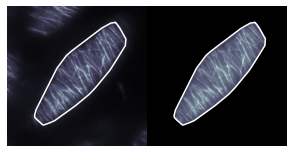

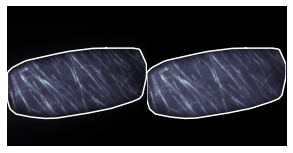

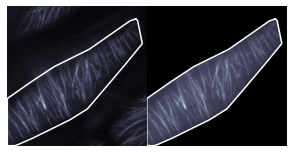

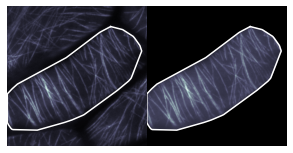

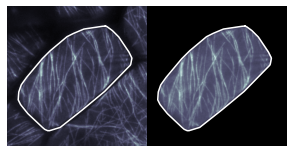

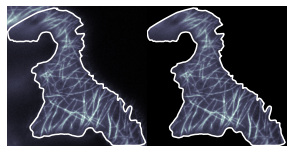

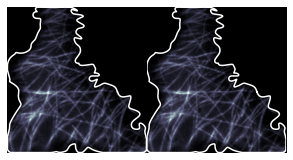

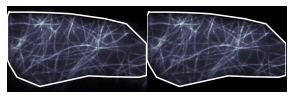

In [5]:
for j in range(len(DATA)):
    fn = FILES[j][0:2]
    Zo = DATA[j][0,:,:]; X = POLOBJS[j][1]; Y = POLOBJS[j][2];
    pix = POLOBJS[j][0];
    plotmask(Zo,X,Y,pix,fn)

# Background estimation

In [6]:
def scaleZ(Z,pix):

    #APPLY MASK AND GET MAXIMUM FLOURESCENCE VALUE
    
    ZS = np.zeros(Z.shape);
    mins = []; maxs = [];
    
    for k in range(Z.shape[0]):
        for pix in px:
            ZS[k,pix[1],pix[0]] = Z[k,pix[1],pix[0]]
        
    MAX = np.max(ZS)
    ZS = ZS/MAX;
    print(ZS.shape)
    return ZS

In [7]:
SDATA = []
for j in range(len(DATA)):
    px = POLOBJS[j][0];
    SDATA.append(scaleZ(DATA[j],px))

(200, 512, 512)
(300, 512, 512)
(200, 512, 512)
(200, 512, 512)
(200, 512, 512)
(200, 512, 512)
(300, 370, 354)
(300, 314, 512)


In [8]:
def bgk(Z,name,dwn):
    fig, (ax,ax2) =  plt.subplots(1,2,figsize=(10,5))
    
    DATY = []; DATX = []; AVDATX = []; AVDATY = []
    MXYN = [];
    
    print(Z.shape)
    
    for q in range(Z.shape[0]):
        BA = Z[q,:,:]
        BB = BA[BA > 0]

        nx = np.unique(BB)
        ny = []
        for nj in nx:
            dyj = BB[BB == nj];
            ny.append(len(dyj))
        MXYN.append(np.max(ny))
        wnx = []
        wny = []
        dn = dwn
        for j in range(0,len(nx)-dn):
            wnx.append(np.mean(nx[j:j+dn]))
            wny.append(np.mean(ny[j:j+dn]))
    
        AVDATX.append(wnx);
        AVDATY.append(wny);
        ax.plot(nx,np.asarray(ny),'o', alpha=0.15);
        ax2.plot(wnx,wny,color='black',alpha=0.01)  
    
    THX=[]
    THY=[]
    for j in range(Z.shape[0]):
    
        ax.plot(AVDATX[j],AVDATY[j], color='black');
    
        ymax = max(AVDATY[j])
        xj = AVDATY[j].index(ymax)
        xmax = AVDATX[j][xj]
        THX.append(xmax);
        THY.append(ymax);
    
    print(np.max(MXYN))
    ymx = np.max(MXYN)
    ax.vlines(THX,0,2.0*ymx,color='black',linestyle='-', alpha=0.01)
    ax2.vlines(THX,0,2.0*ymx,color='black',linestyle='-', alpha=0.01)
    
    ax.set_ylim([0,1.1*ymx])
    ax2.set_ylim([0,1.1*ymx])

    ax.set_xlabel('Signal Value')
    ax.set_ylabel('Number of pixels equal to x')

    ax2.set_xlabel('Signal Value')
    ax2.set_ylabel('Sliding window number of pixels equal to x')

    fig.suptitle(name)
    fig.savefig("BKG"+name+".png", dpi=150,bbox_inches='tight',pad_inches =0, transparent= False, facecolor='white')
    
    return THX;

(200, 512, 512)
49
(300, 512, 512)
32
(200, 512, 512)
74
(200, 512, 512)
72
(200, 512, 512)
74


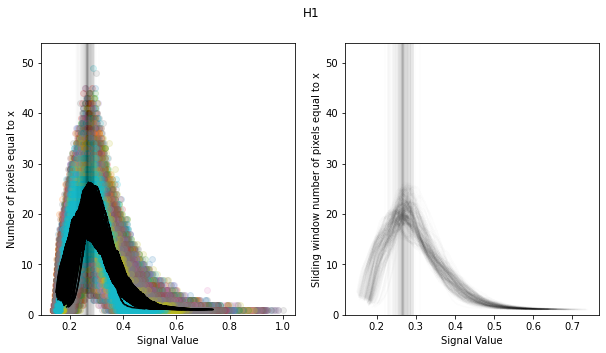

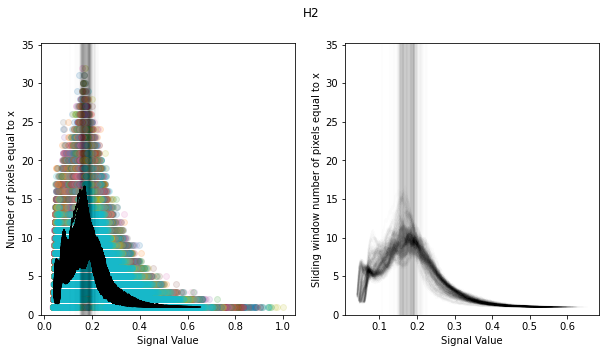

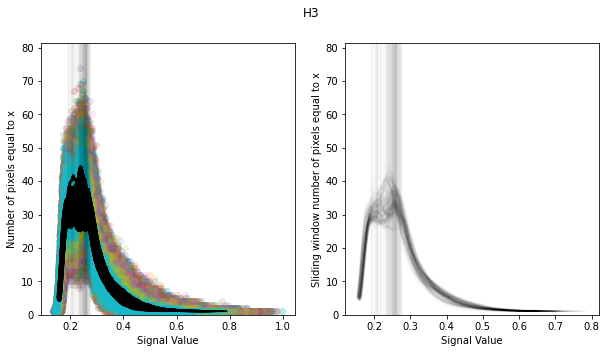

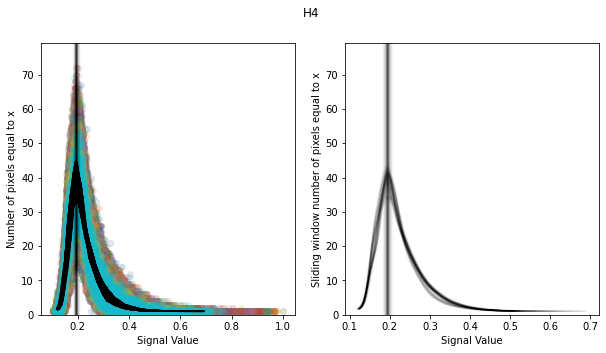

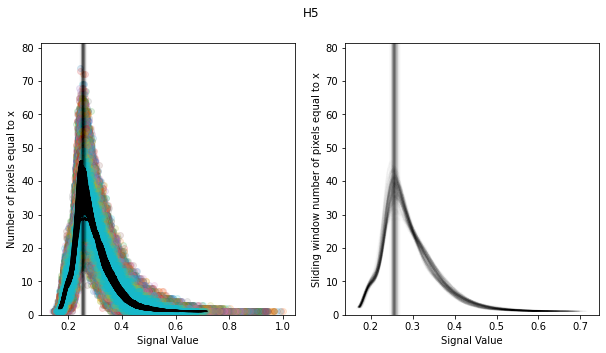

In [9]:
##Hypocotyls
HTH = []
for j in range(5):
    fn = FILES[j][0:2]
    HTH.append(bgk(SDATA[j],fn,250))

(200, 512, 512)
3793
(300, 370, 354)
1858
(300, 314, 512)
2591


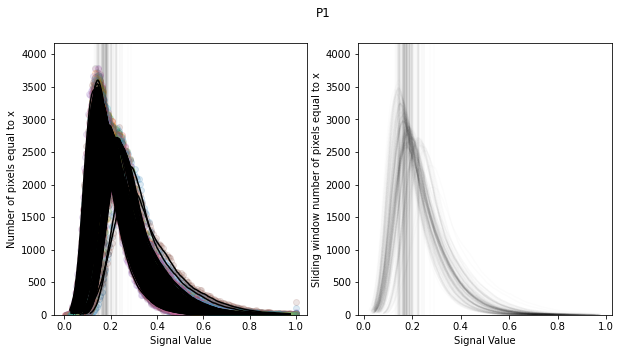

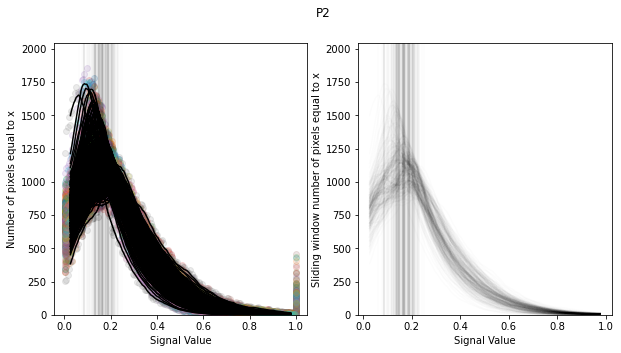

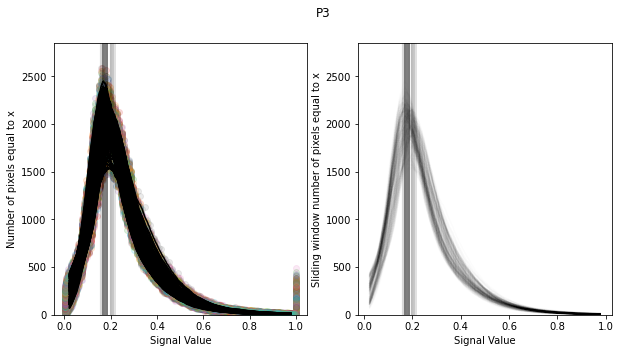

In [10]:
##Hypocotyls
PTH = []
for j in range(5,8):
    fn = FILES[j][0:2]
    PTH.append(bgk(SDATA[j],fn,10))

In [11]:
HBKG = [np.mean(j) for j in HTH]
HSBKG = [np.std(j) for j in HTH]
PBKG = [np.mean(j) for j in PTH]
PSBKG = [np.std(j) for j in PTH]

BGN = [i-j for i,j in zip(HBKG,HSBKG)] + [i-j for i,j in zip(PBKG,PSBKG)]

#BGN = HBKG + PBKG

print(BGN)

[0.2529905672998476, 0.15944001403743, 0.22453896830955838, 0.1903762615470442, 0.2522394470204092, 0.15328629876549477, 0.12922218758618242, 0.16760664438181513]


# Tubule Calibration.

In [113]:
def tubules(fn):
    A=pd.read_csv(segs)
    return A

def boxes(Z,A,B,lj,dn,meanth,name,polygon):
    NB = len(B);
    
    xn = polygon[1]; yn = polygon[2];
    
    filament = []
    frame =[]
    Ln = []
    
    for j in B:
        Qn = A.loc[A['Slice']== j]
        X = [lj*k for k in list(Qn['X'])];Y=[lj*k for k in Qn['Y']];
        Zm = Z[j,:,:]
        
        fig, (ax1,ax2, ax3, ax4, ax5) =  plt.subplots(1,5,figsize=(15,5))
        ax1.imshow(Zm,cmap='bone')
        ax1.set_axis_off()
        
        Zn = Zm - meanth
        Zn[Zn<0] = 0.0
        ax2.imshow(Zn,cmap='bone')
        ax2.plot(X,Y,c='yellow')
        ax2.set_axis_off()
        
        
        X1=X[0];Y1=Y[0];
        X2=X[1];Y2=Y[1];
        
        if Y1 < Y2:
            Xa = X1
            Xb = X2
            Ya = Y1
            Yb = Y2
        else:
            Xa = X2
            Xb = X1
            Yb = Y1
            Ya = Y2
    
        Ux=Xb-Xa
        Uy=Yb-Ya
        R=np.sqrt(Ux**2+Uy**2)
        angle=np.arccos(Ux/R)
        angdeg=angle*(180/np.pi)
        Vx=Ux*np.cos(angle)+Uy*np.sin(angle)
        Vy=Ux*np.sin(angle)-Uy*np.cos(angle)
        Q = rotate(Zm,angdeg,center=(Xa,Ya),resize=False,preserve_range=True)
        Qn = rotate(Zn,angdeg,center=(Xa,Ya),resize=False,preserve_range=True)
        ax3.imshow(Qn,cmap='bone')
        ax3.plot([Xa,Xa+R],[Ya,Ya],color='yellow')
        ax3.set_axis_off()
        n1=int(Xa)
        n2=int(Xa+R)
        m1=int(Ya)-dn
        m2=int(Ya)+dn
        P = Q[m1:m2,n1:n2]
        ax4.imshow(P,cmap='bone')
        ax4.set_axis_off()
        
        Qr = P - meanth
        Qr[Qr<=0] = 0.0 
        
        filament.append(Qr)
        Ln.append(R)
        
        ax5.imshow(Qr,cmap='bone')
        ax5.set_axis_off()
        plt.subplots_adjust(wspace=0.1, hspace=0)
        fig.suptitle('Slice: '+str(j), fontsize=16) 
        fig.savefig(name+"_SLC_"+str(j)+".png", dpi=150,bbox_inches='tight',
                    pad_inches =0)#, transparent= False, facecolor='white')
        
    return filament, Ln

def Io(Q,Lm,nj,name):
    fig, (ax,ax2) =  plt.subplots(1,2,figsize=(10,5))
    ax2.set_axis_off();
    N= Q.shape
    Na=Lm
    print(N)
    Mo = Q.shape[0]
    no = int(0.5*N[0])
    dn=[0]
    In=[0]
    n1 = no
    n2 = no+1
    print('-----')
    print(n1,n2)
    print('-----')
    ax2.axhline(n1-0.5,color='red',linestyle='--')
    ax2.axhline(n2-0.5,color='red',linestyle='--')
    P = Q[n1:n2,0:Na]
    dn.append(n2-n1)
    In.append(sum(P.ravel()))
    for n in range(no-1):
        n1 -=1
        n2 += 1
        print(n1,n2)
        if n==3: 
            ax2.axhline(n1-0.5,color='white',linestyle='--')
            ax2.axhline(n2-0.5,color='white',linestyle='--')
            
        if n==4: 
            ax2.axhline(n1-0.5,color='blue',linestyle='--')
            ax2.axhline(n2-0.5,color='blue',linestyle='--')
            
        P = Q[n1:n2,:]
        dn.append(n2-n1)
        In.append(sum(P.ravel()))
        #if n == 6:
        ax2.imshow(P,cmap='bone')  
    
    ax.plot(dn,In, '-o')
    ax.set_xlabel('Box width (px)',fontsize=20)
    ax.set_ylabel('Io',fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    
    ax.xaxis.label.set_color('orange')
    ax.tick_params(axis='x', colors='orange')
    
        
    ax.yaxis.label.set_color('orange')
    ax.tick_params(axis='y', colors='orange')
    
    plt.subplots_adjust(wspace=0.02, hspace=0)
    fig.savefig(name+"_cal"+str(nj)+".png", dpi=150,bbox_inches='tight',
            pad_inches =0)
    
    return dn,In

def plot_avIo(name,lj,Ij,avth,sdth):
    fig, ax =  plt.subplots(1,1,figsize=(10,8))
    for k in range(len(lj)):
        ax.plot(lj[k],Ij[k],'o--')
    ax.axhline(avth,color='blue')
    ax.axhline(avth-sdth,color='black',linestyle='--')
    ax.axhline(avth+sdth,color='black',linestyle='--')
    ax.set_xlabel('Box width (px)',fontsize=20)
    ax.set_ylabel('Io',fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axvline(7)
  
    ax.xaxis.label.set_color('orange')
    ax.tick_params(axis='x', colors='orange')
    
    ax.yaxis.label.set_color('orange')
    ax.tick_params(axis='y', colors='orange')

    fig.savefig("Calibration"+name+".png", dpi=150,bbox_inches='tight',
            pad_inches =0)#, transparent= False, facecolor='white')

def plotLI(name,Lk,Ik):
    #fig, (ax2, ax3)  =  plt.subplots(1,2,figsize=(20,10))
    fig, ((ax2), (ax3))  =  plt.subplots(2,1,figsize=(10,20))
            
    Lkav = np.mean(Lk)
    SLkav = np.std(Lk)
        
    Ikav = np.mean(Ik)
    SIkav = np.std(Ik)
    
    ax2.plot(Lk,'o',c='black',alpha=0.1)
    ax2.axhline(Lkav,color='red')
    ax2.axhline(Lkav+SLkav,linestyle='--')
    ax2.axhline(Lkav-SLkav,linestyle='--')
    ax2.set_ylim([0,2.0*max(Lk)])
    ax2.set_ylabel('Linear polymer length/Area [$\mu m^{-1}$] ',fontsize=20)
    ax2.set_xlabel('Frame ',fontsize=20)

    ax3.plot(Ik,'o',c='black',alpha=0.1)
    ax3.axhline(Ikav,color='red')
    ax3.axhline(Ikav+SIkav,linestyle='--')
    ax3.axhline(Ikav-SIkav,linestyle='--')
    ax3.set_ylim([0,2.0*max(Ik)])
    ax3.set_ylabel('Amount of Polymer/Area [($\mu m)^{-2]}$] ',fontsize=20)
    ax3.set_xlabel('Frame ',fontsize=20)

    for k in [ax2,ax3]:
        k.xaxis.label.set_color('orange')
        k.tick_params(axis='x', colors='orange')
        k.yaxis.label.set_color('orange')
        k.tick_params(axis='y', colors='orange')
    
    ax2.xaxis.set_tick_params(labelsize=15)
    ax2.yaxis.set_tick_params(labelsize=15)
    ax3.xaxis.set_tick_params(labelsize=15)
    ax3.yaxis.set_tick_params(labelsize=15)
    
    fig.savefig(name+"_Results.png", dpi=150,bbox_inches='tight',
            pad_inches =0)#, facecolor='white')

In [114]:
tubfiles = ['H'+str(k)+'/'+'H'+str(k)+'tubs.csv' for k in range(1,6) ]+[
            'P'+str(k)+'/'+'P'+str(k)+'tubs.csv' for k in range(1,4)]
TUBS = [pd.read_csv(j) for j in tubfiles]

(18, 12)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 18)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
[[0, 1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 1, 3, 5, 7, 9, 11, 13, 15, 17]]
3.565960857029535 1.3850794798780894
(18, 11)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 8)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 13)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 13)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
[[0, 1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 1, 3, 5, 7, 9, 11, 13, 15, 17]]
2.5845861621200865 1.9800264318456549
(18, 11)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 15)
-----
9 10
-----


/tmp/ipykernel_237456/3247820251.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax,ax2) =  plt.subplots(1,2,figsize=(10,5))


8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 15)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
[[0, 1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 1, 3, 5, 7, 9, 11, 13, 15, 17]]
5.474420926604055 2.9213444704518237
(18, 11)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 9)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 14)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
[[0, 1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 1, 3, 5, 7, 9, 11, 13, 15, 17], [0, 1, 3, 5, 7, 9, 11, 13, 15, 17]]
0.5750186925379623 0.24600298944404536
(18, 15)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 20)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 17)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 20)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 11)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 18)
-----
9 10
-----
8 11
7 12
6 13
5 14
4 15
3 16
2 17
1 18
(18, 17

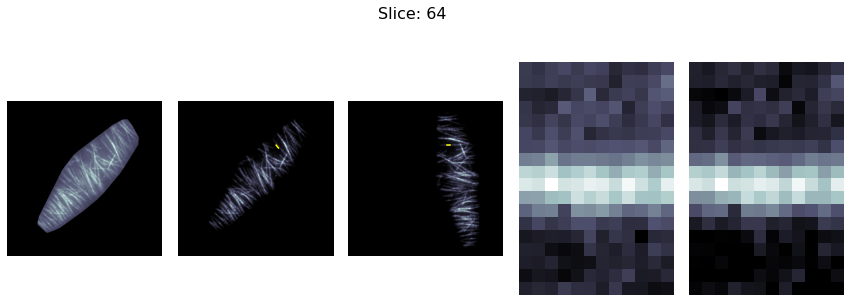

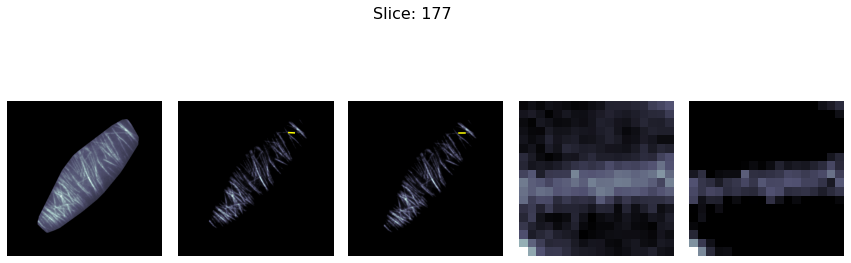

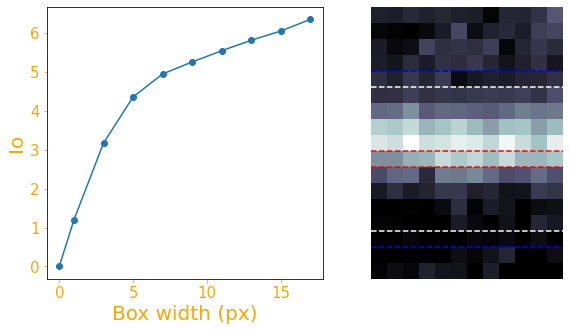

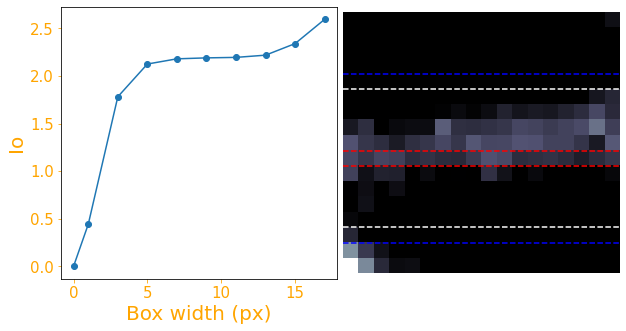

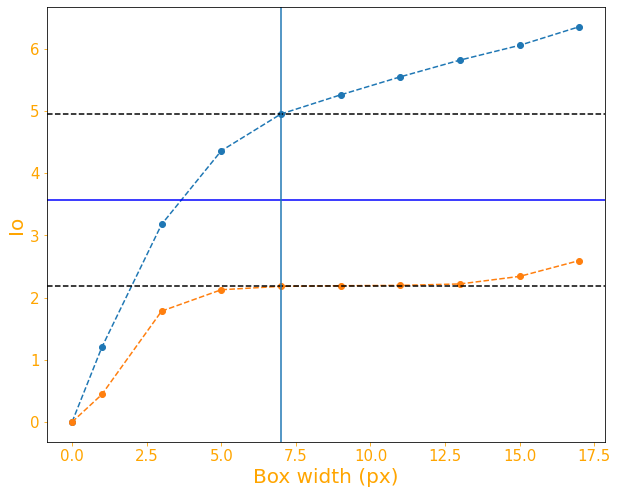

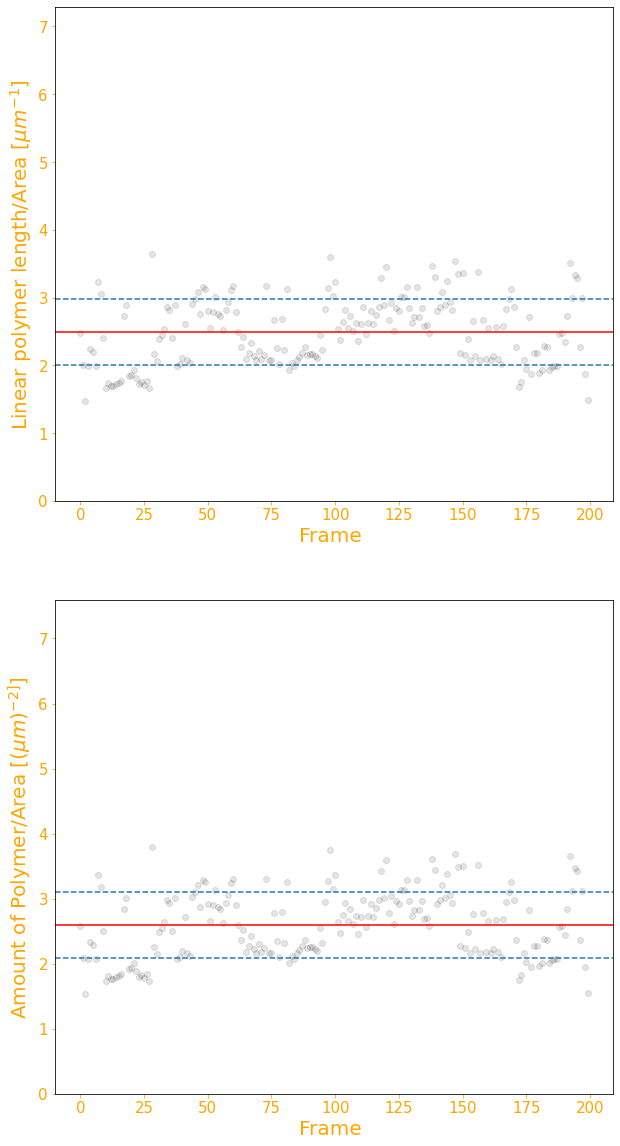

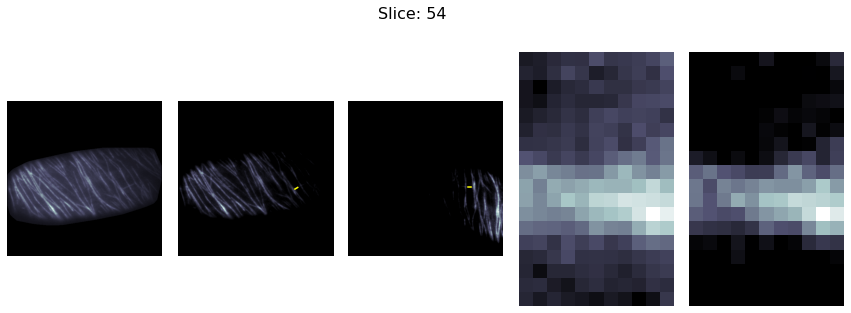

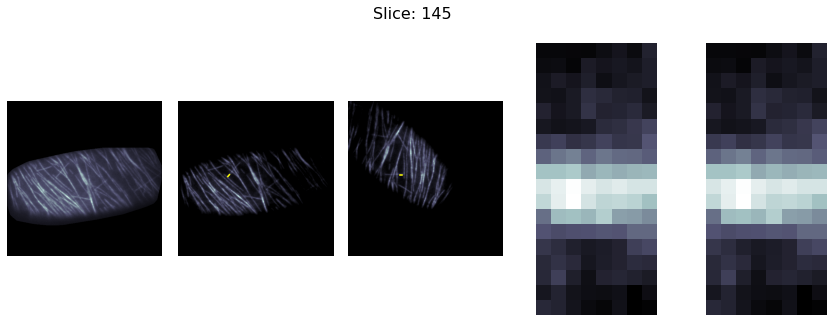

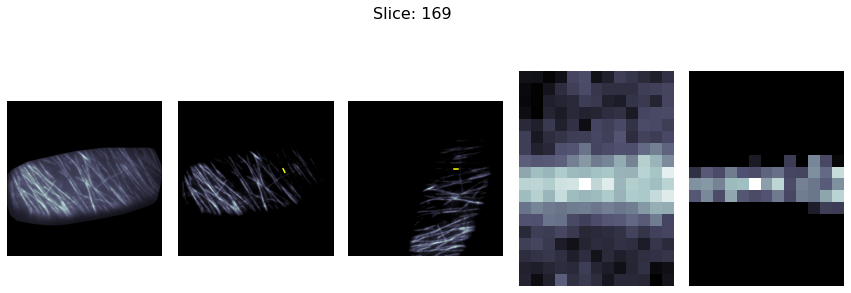

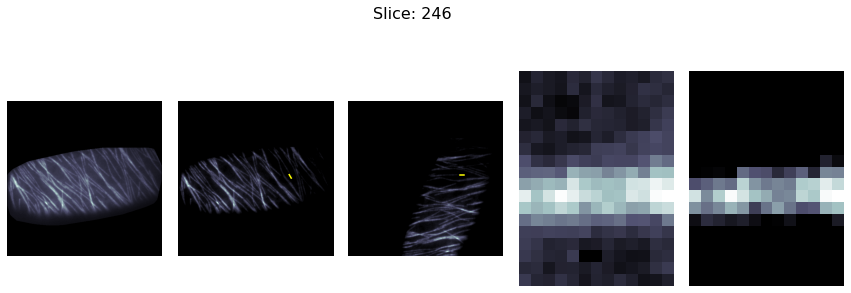

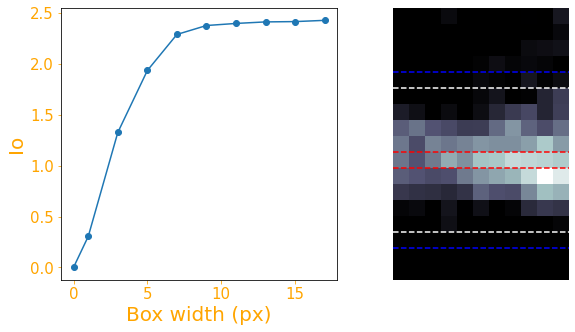

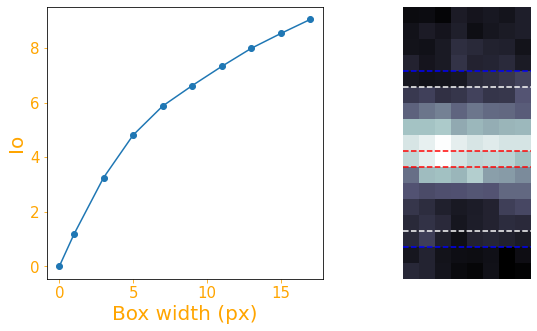

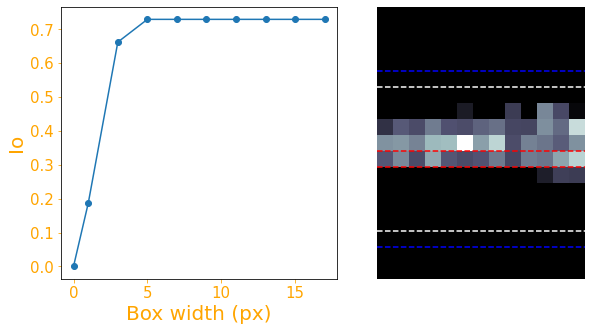

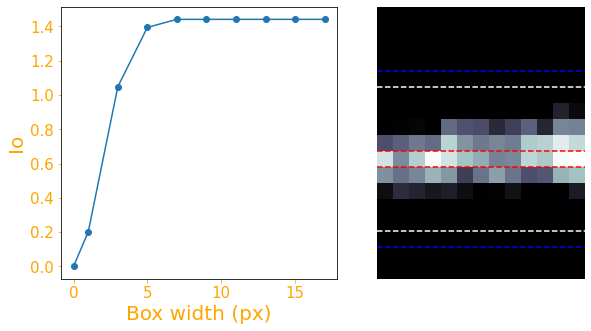

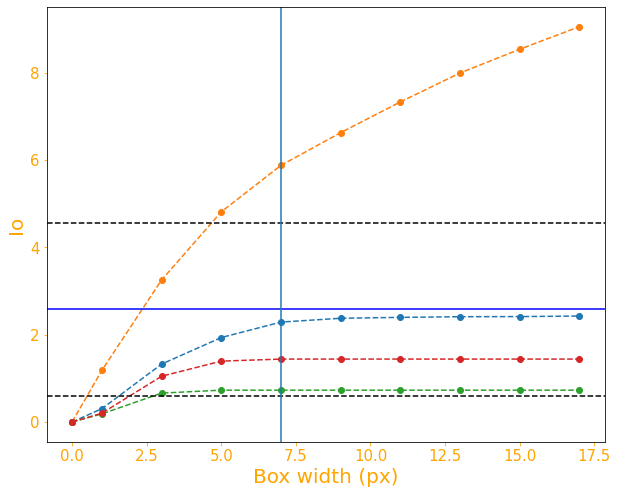

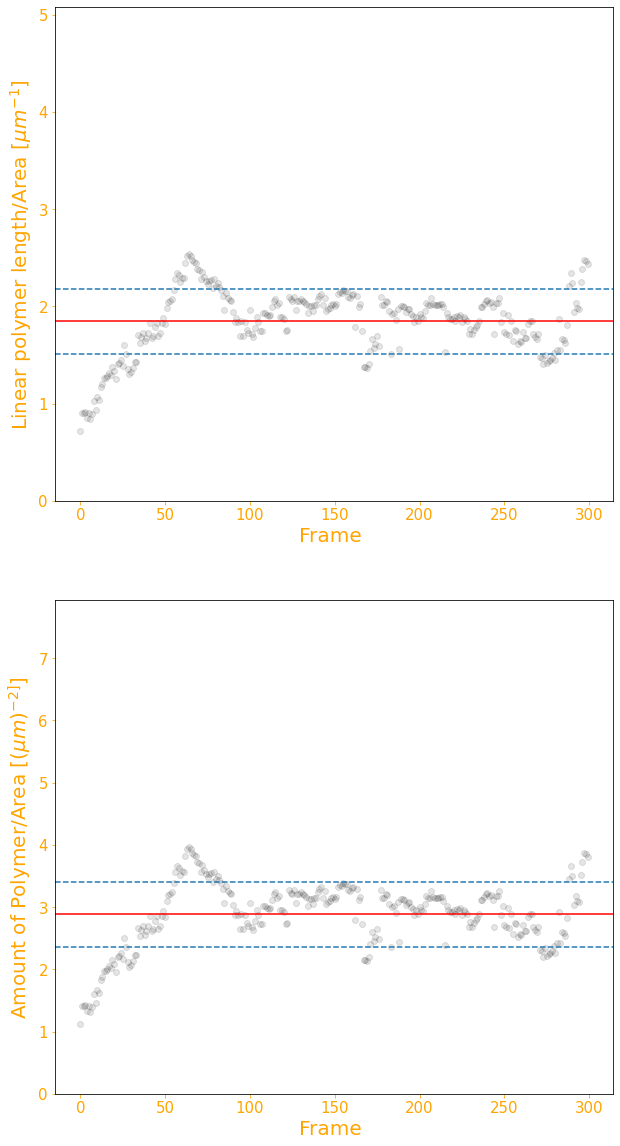

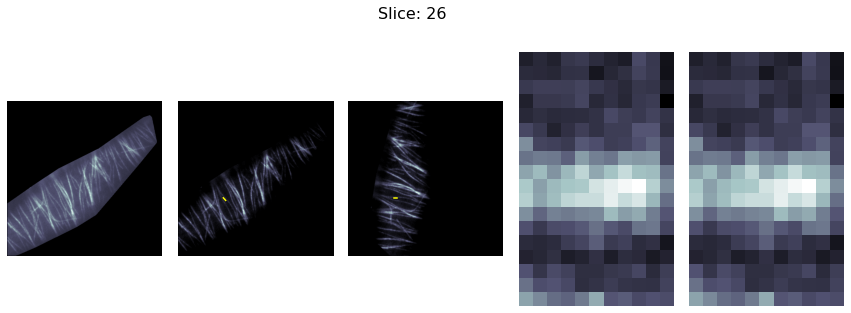

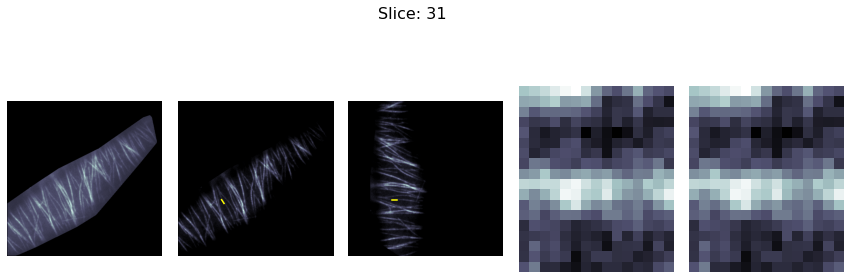

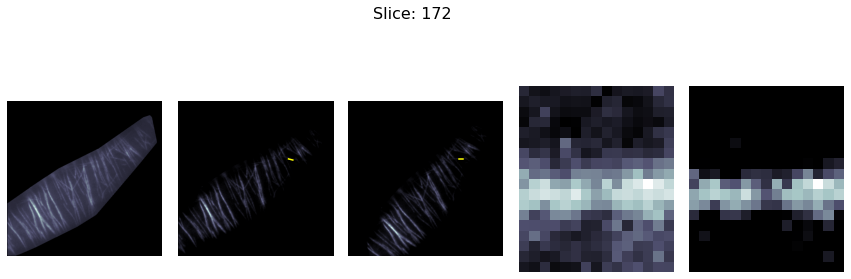

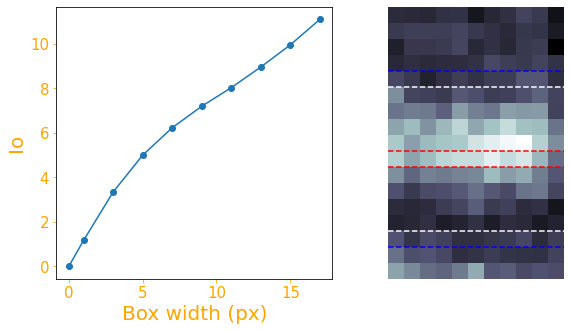

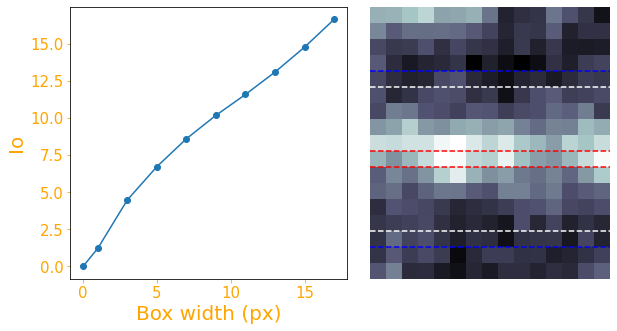

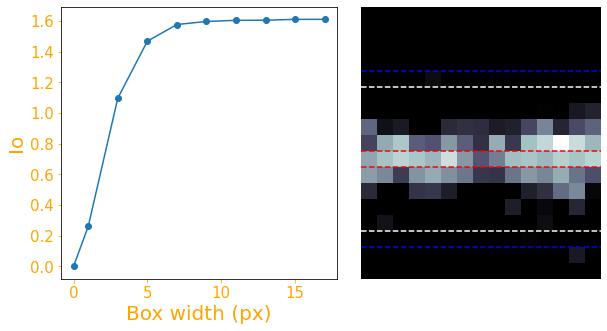

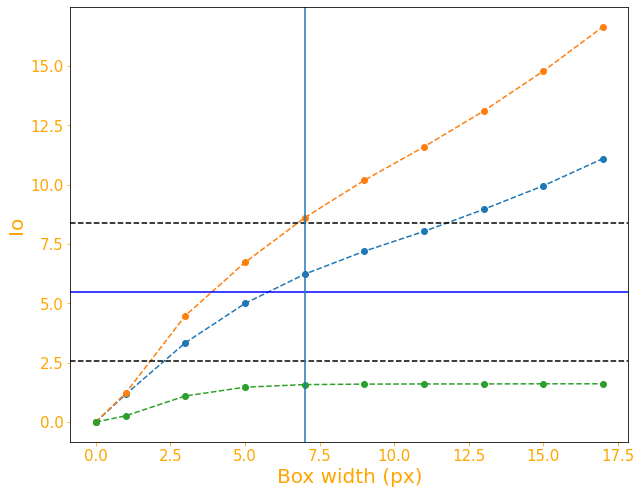

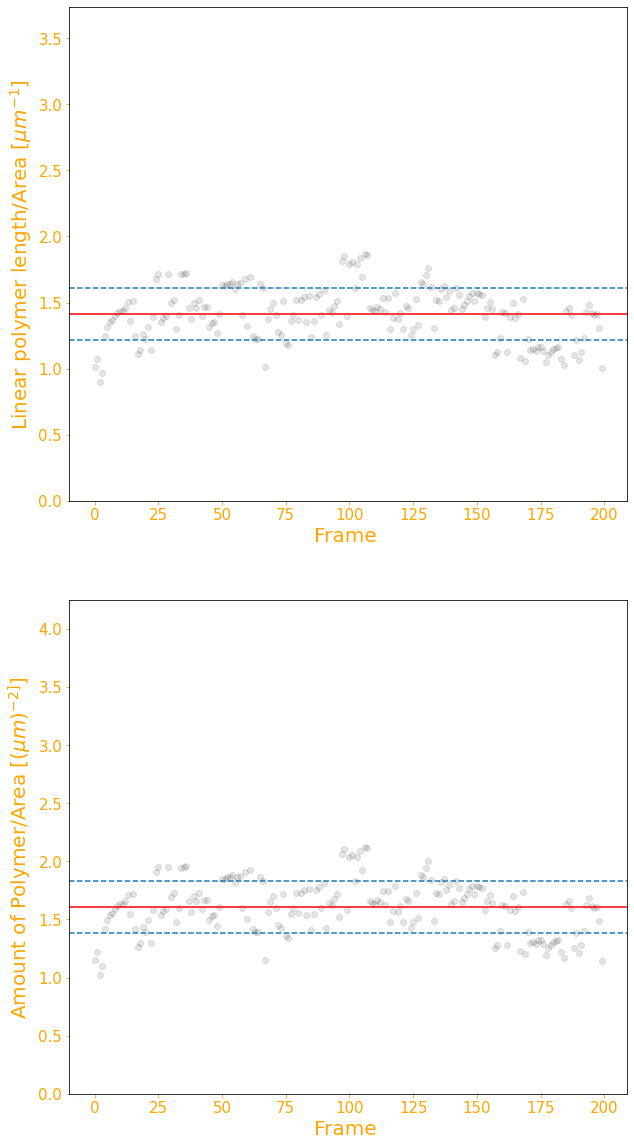

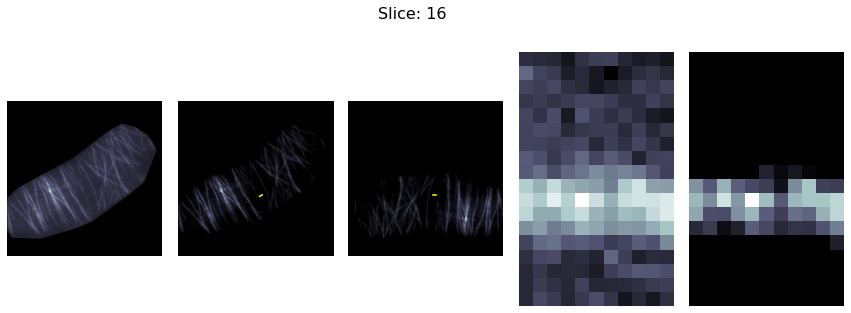

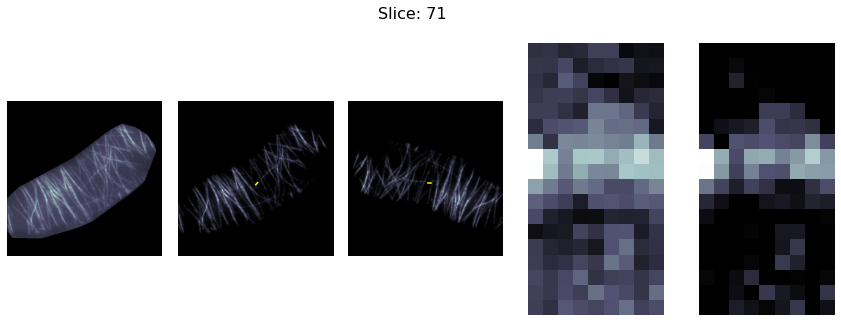

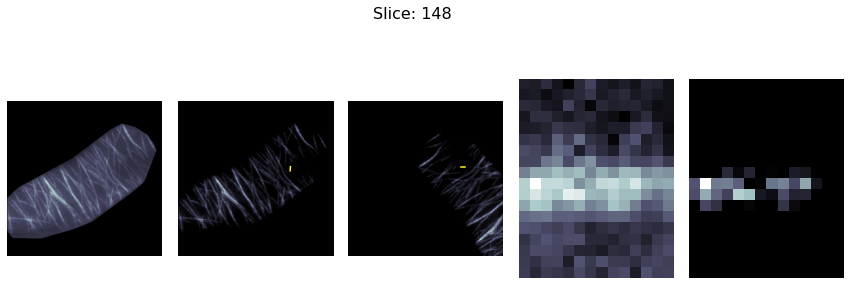

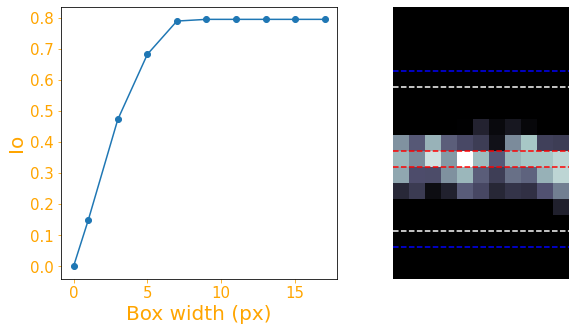

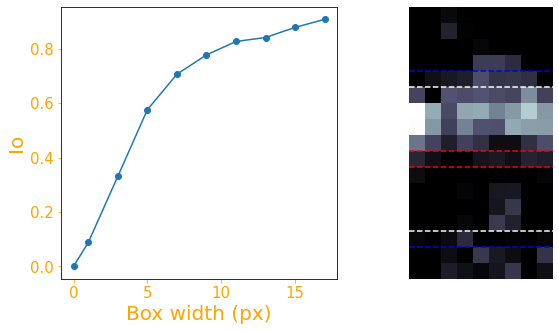

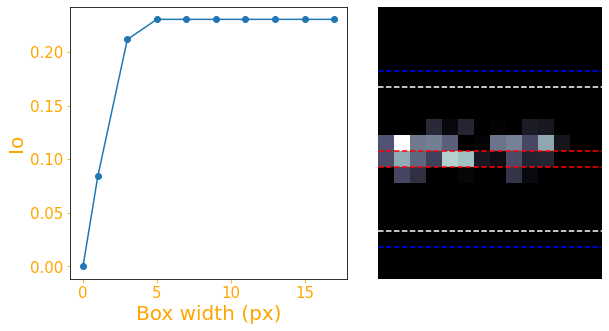

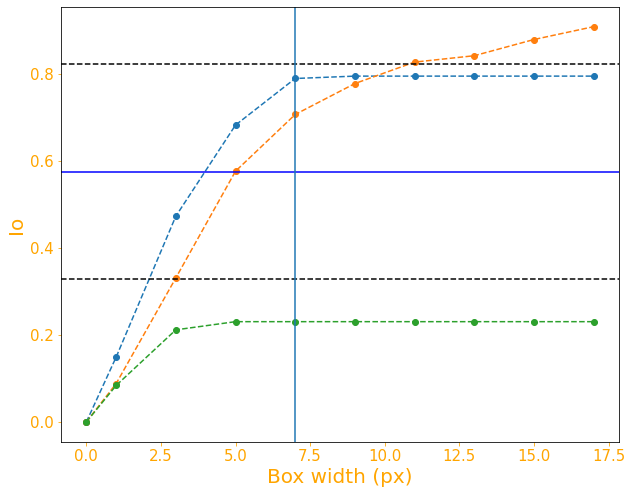

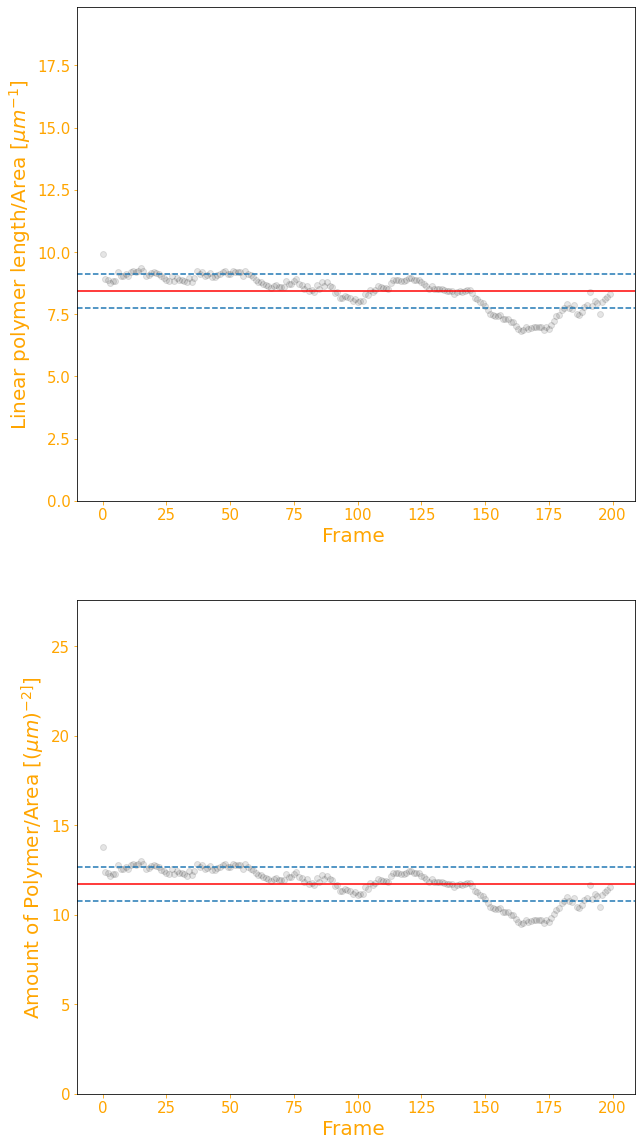

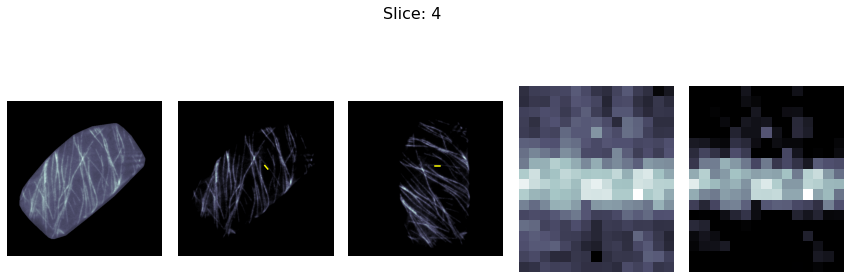

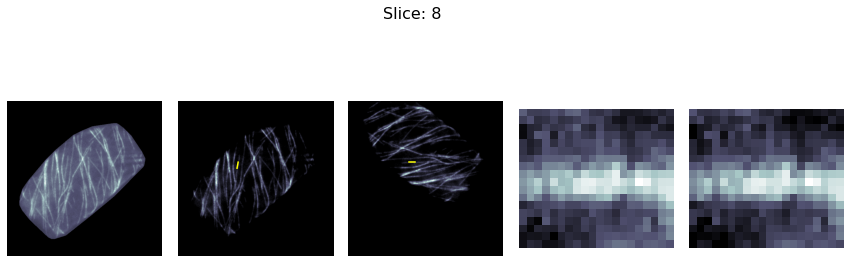

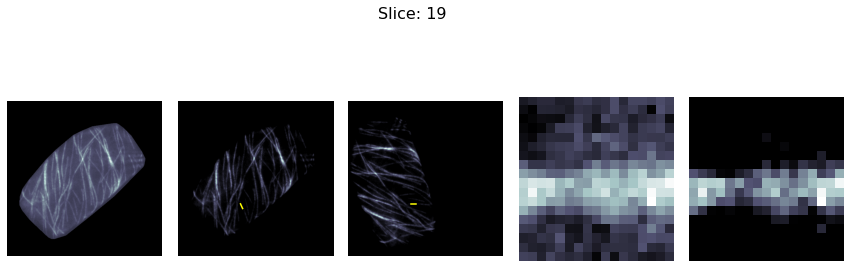

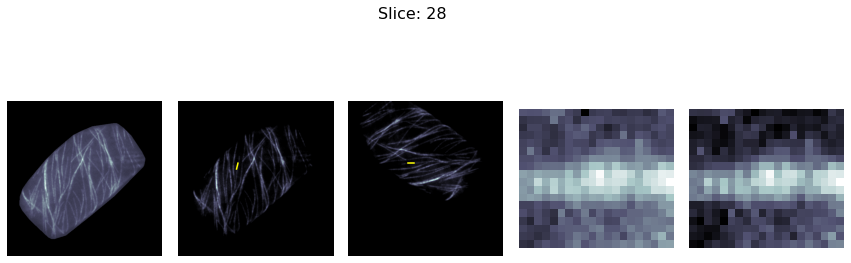

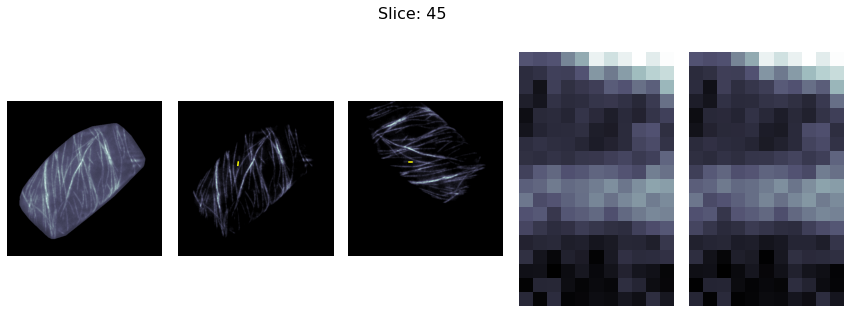

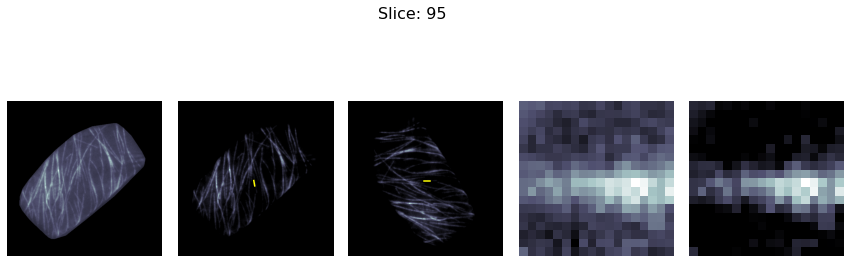

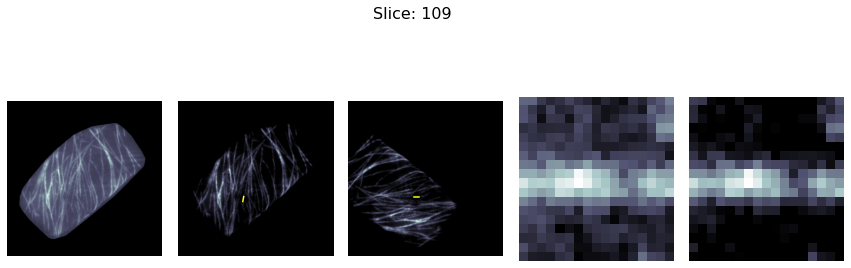

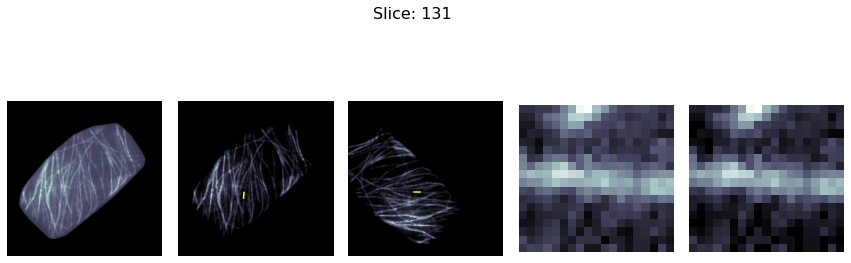

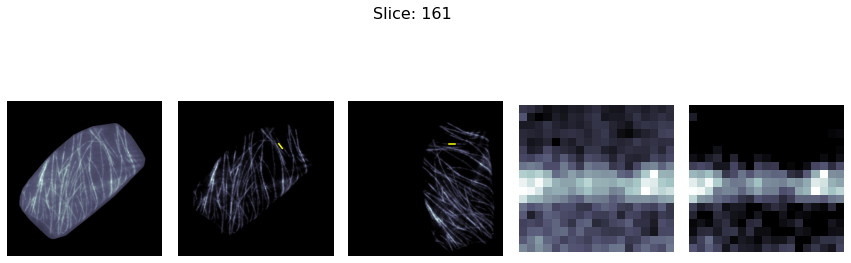

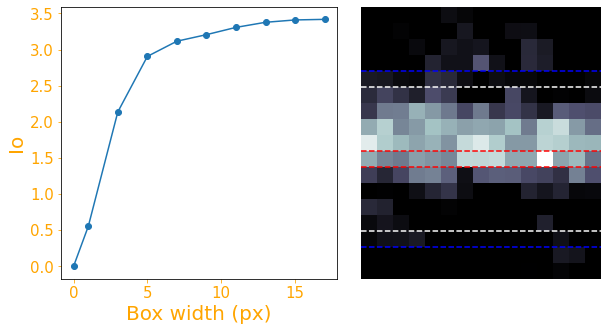

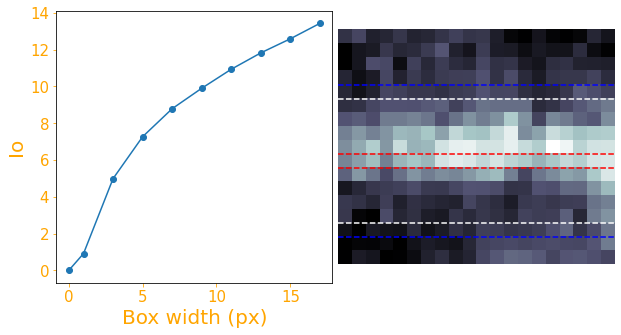

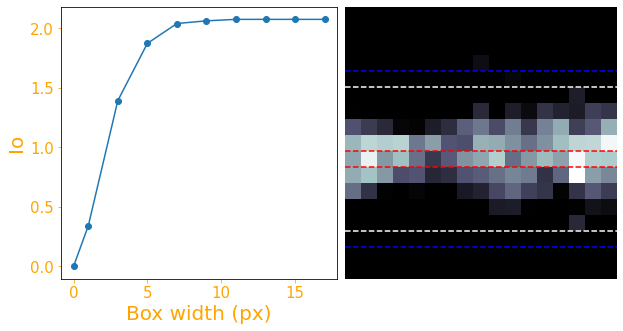

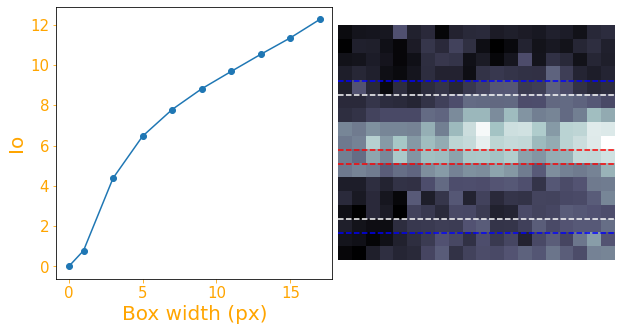

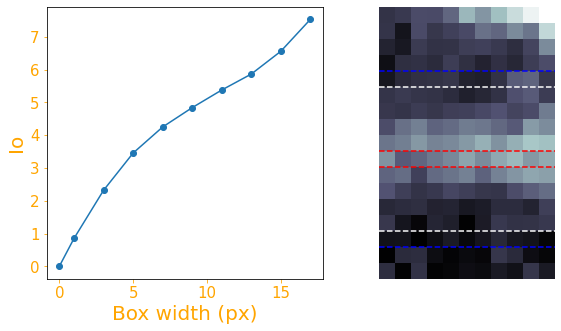

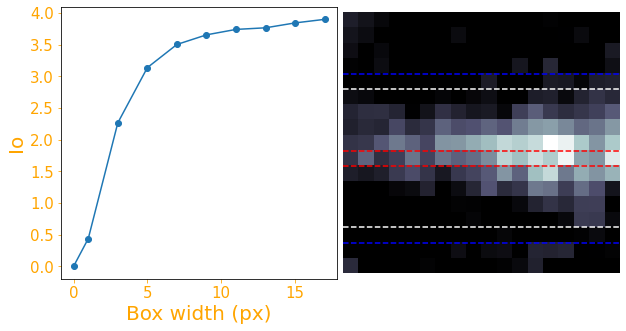

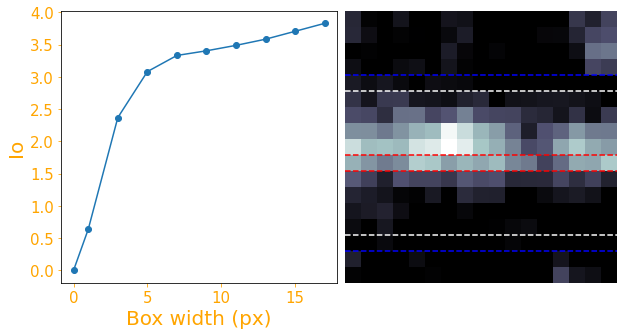

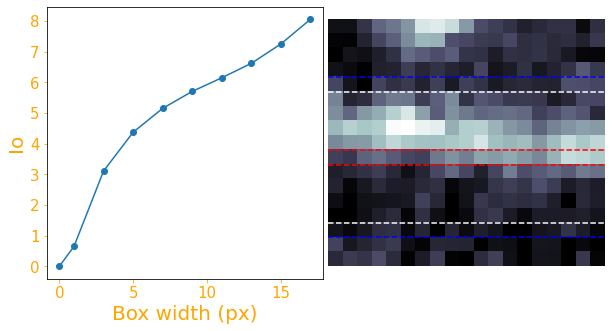

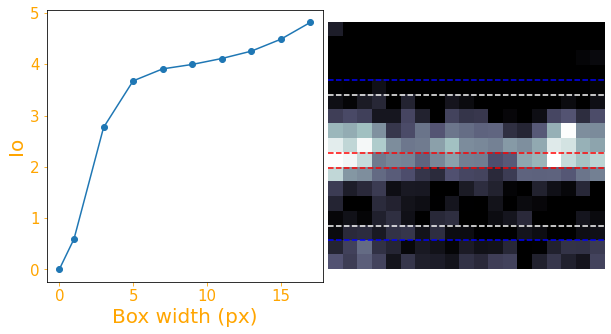

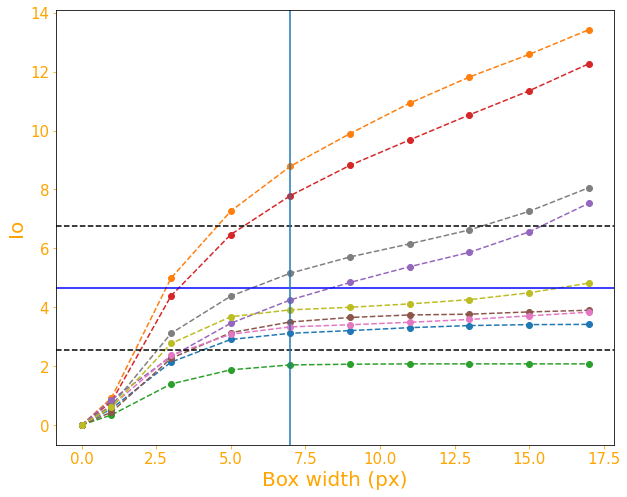

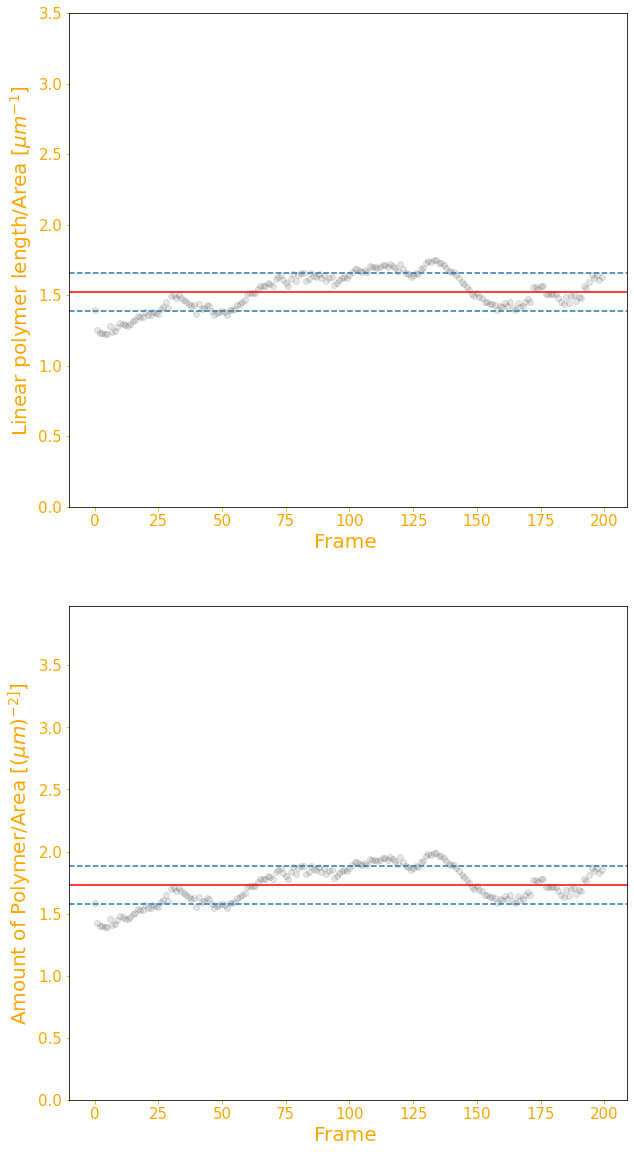

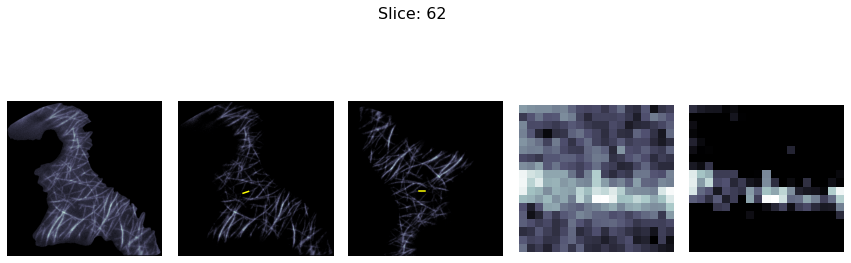

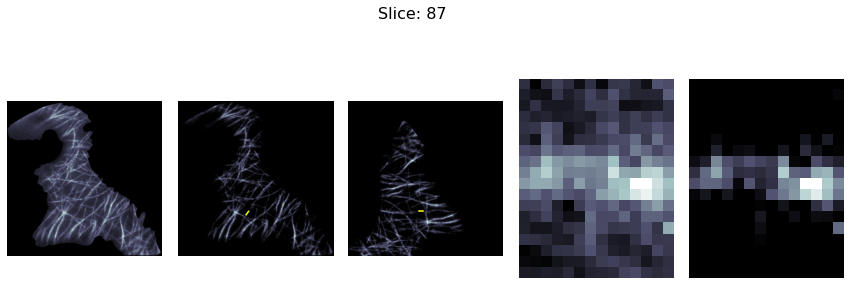

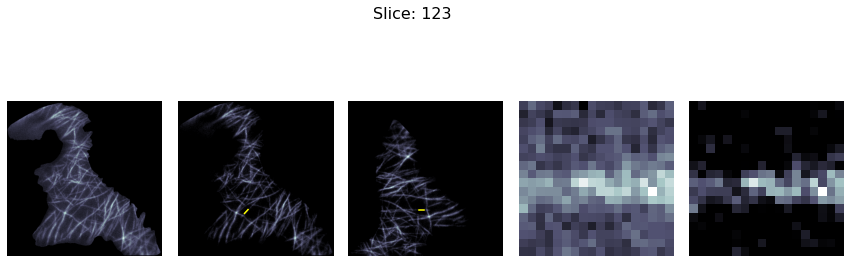

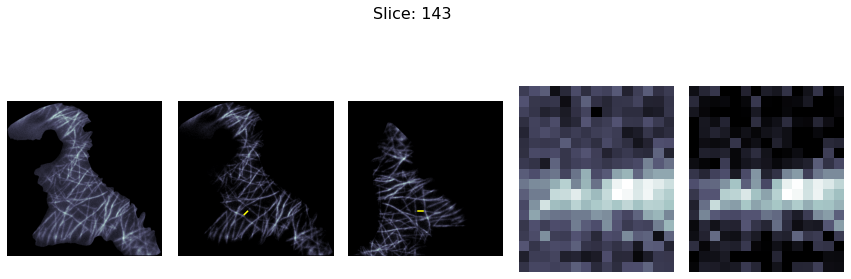

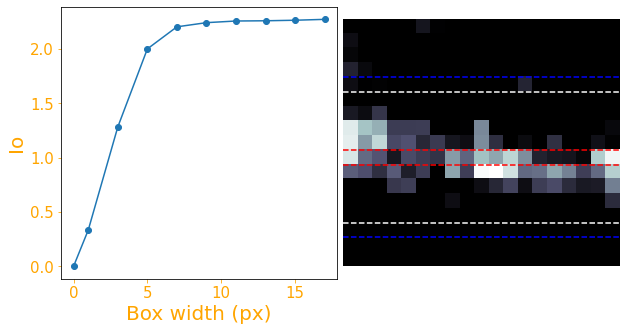

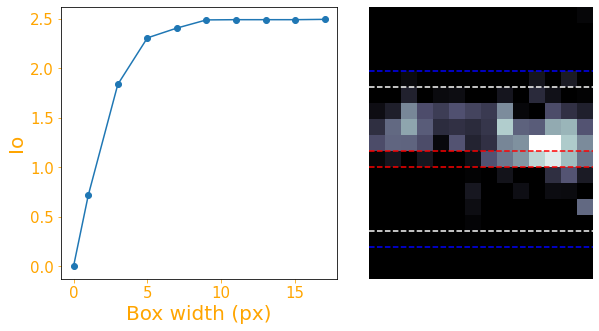

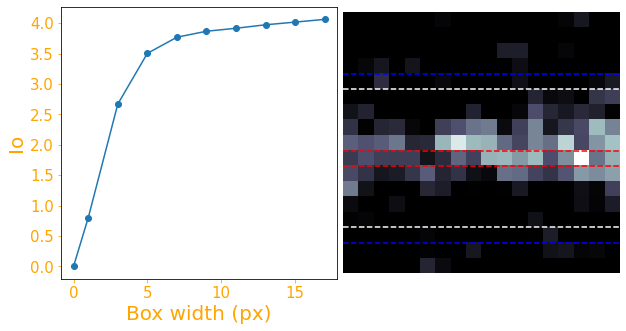

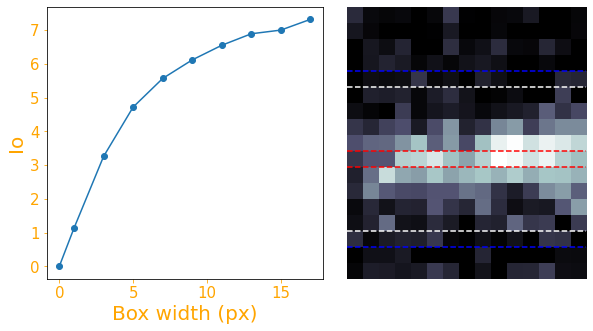

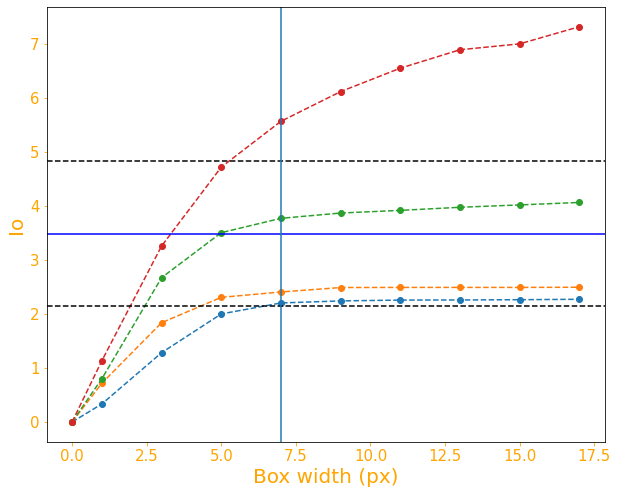

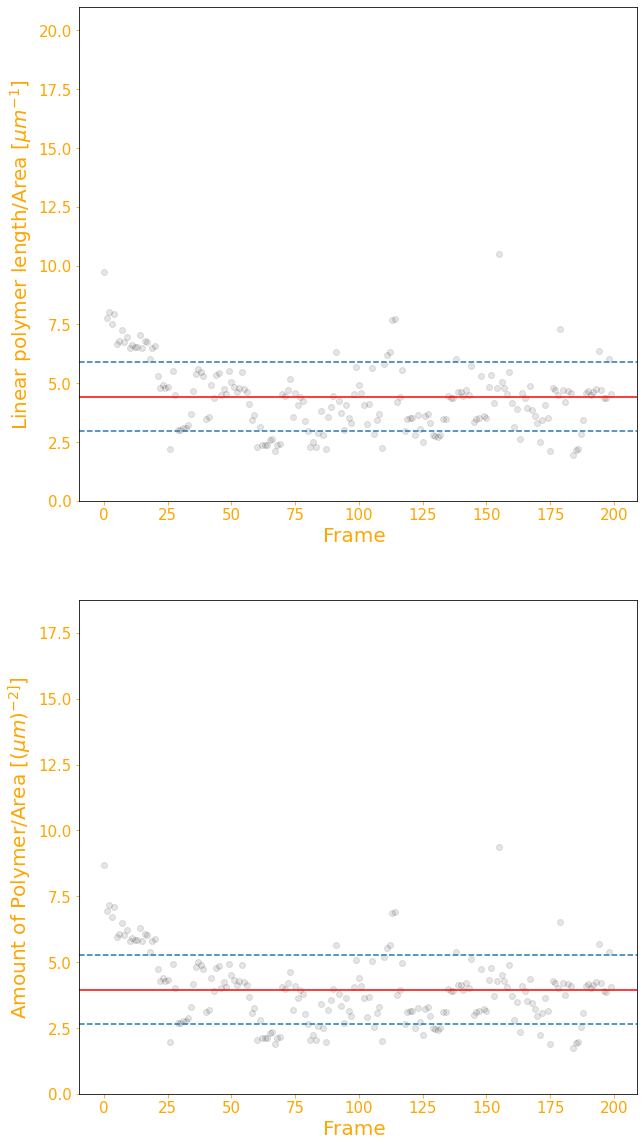

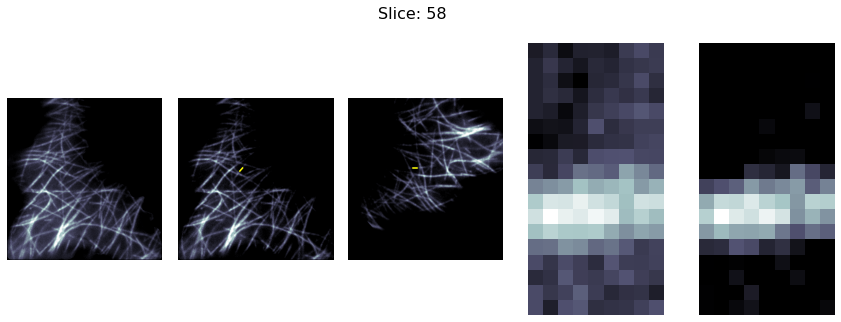

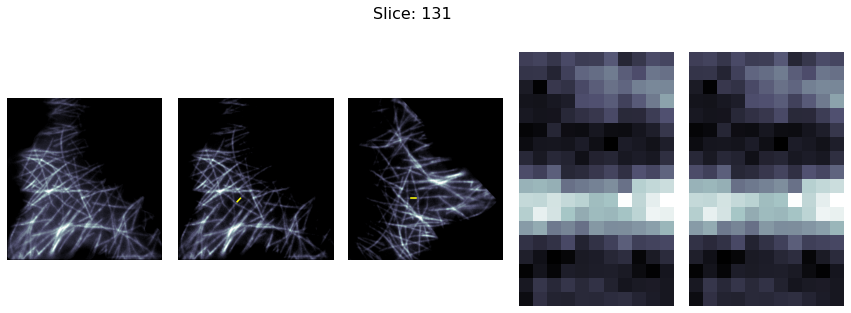

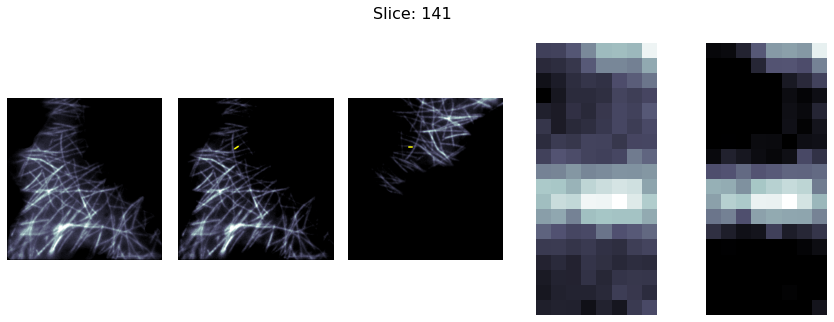

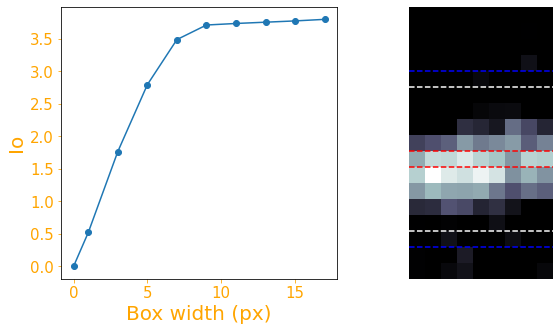

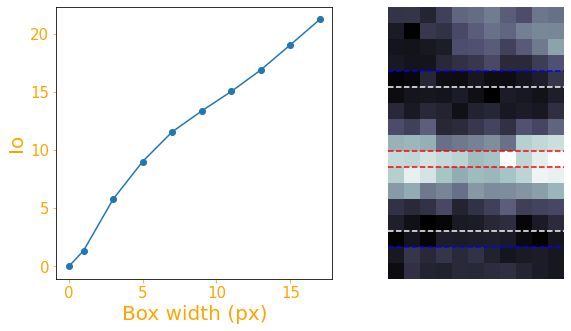

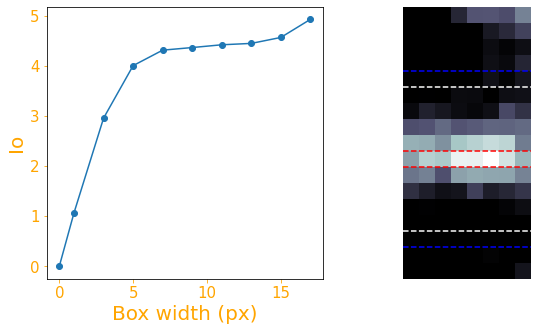

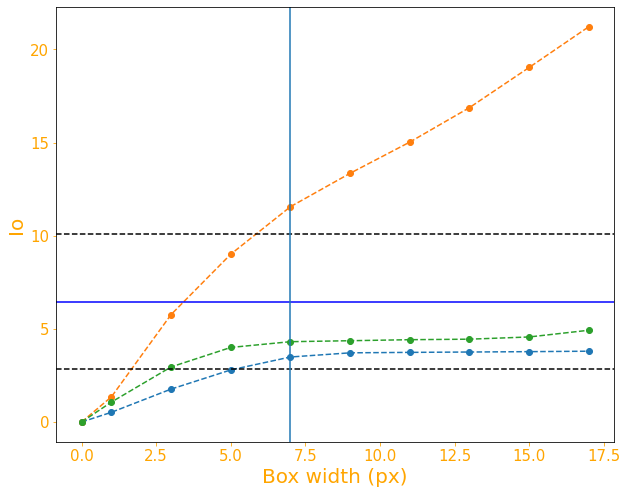

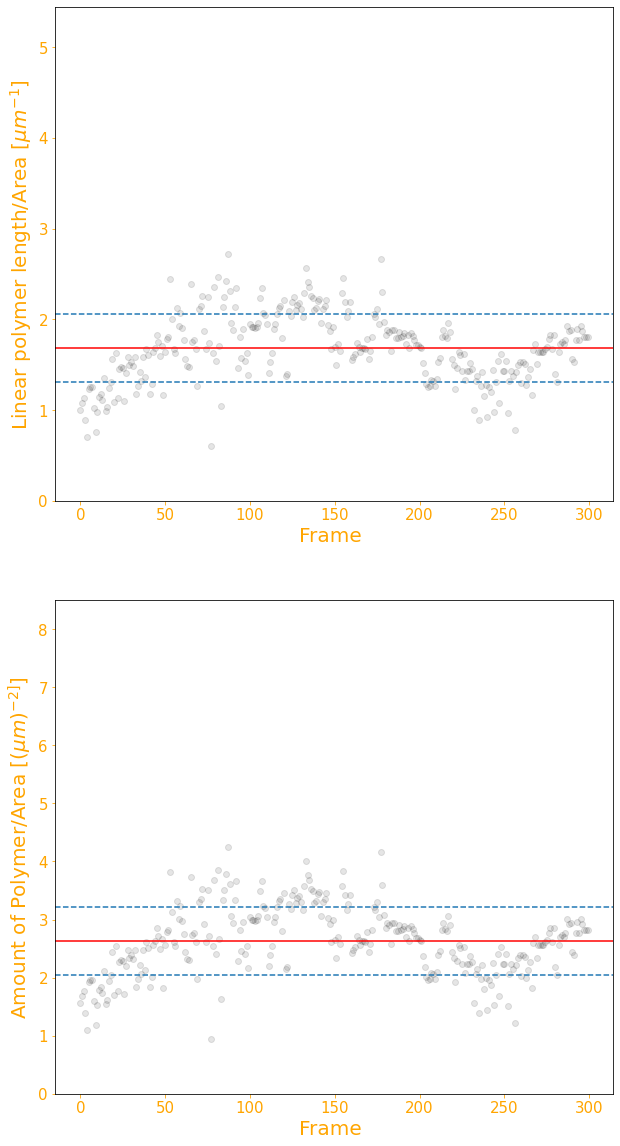

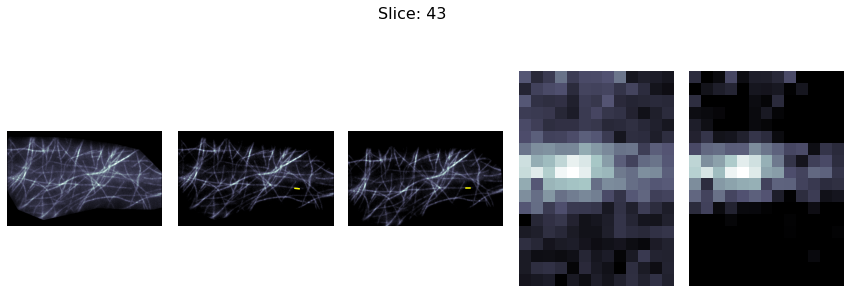

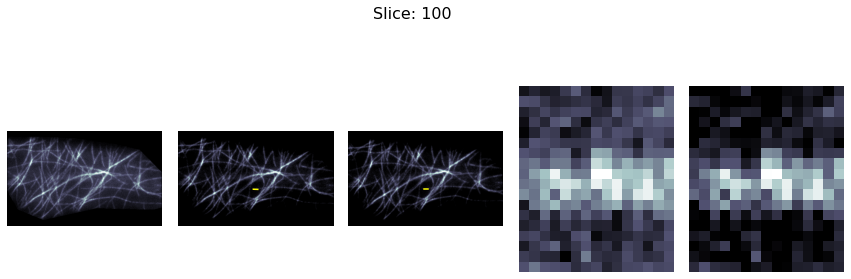

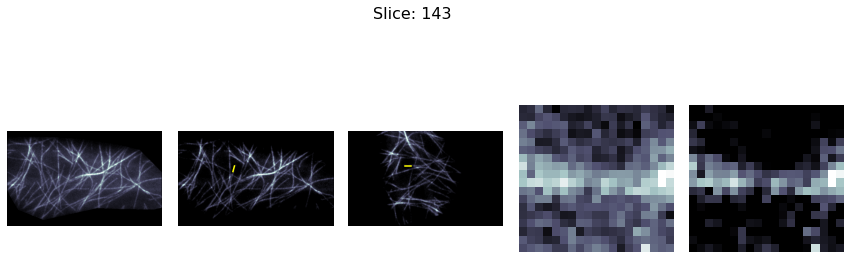

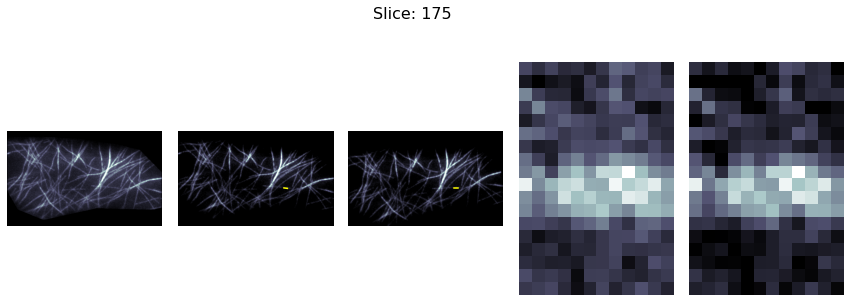

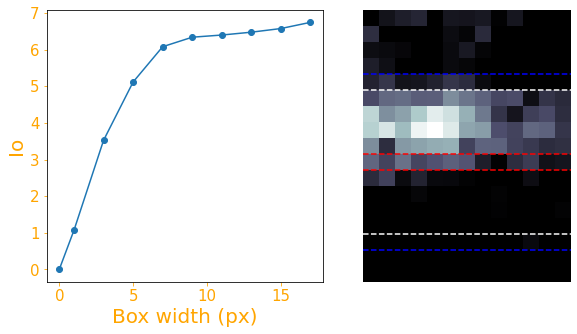

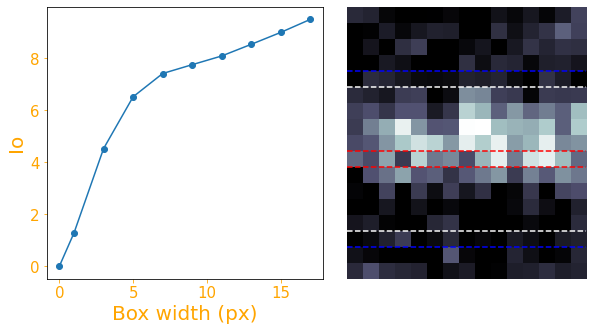

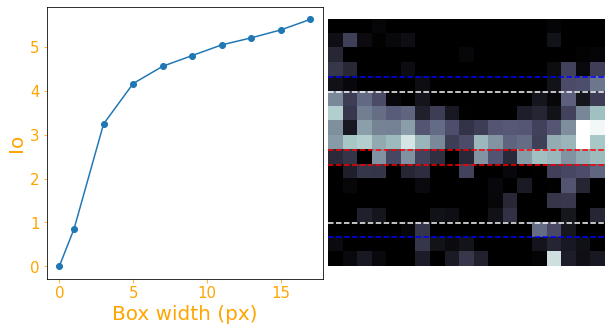

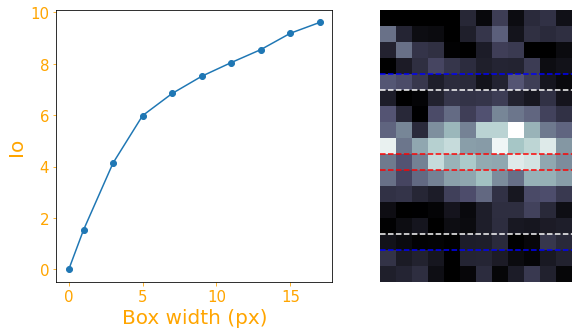

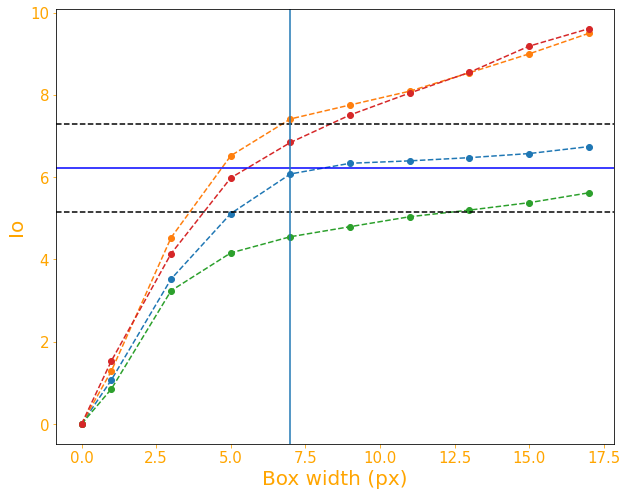

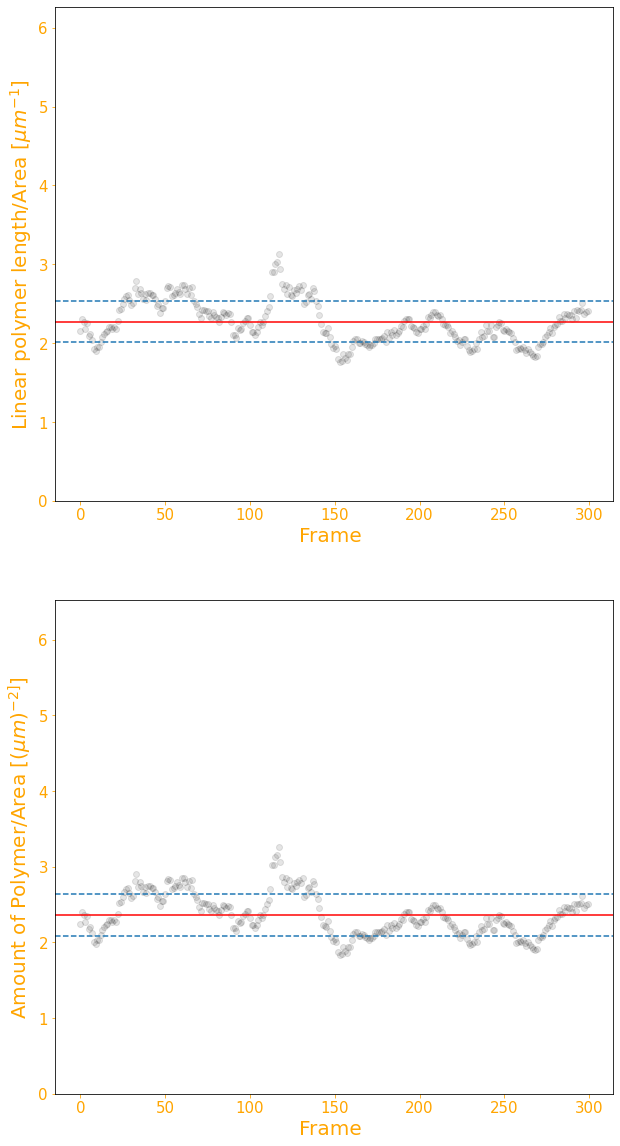

In [115]:
rj=512/40.96; 
Cells  =[];  Ctypes = []; MeanLn = []; 
SdLn =[]; MeanIn =[]; SdIn = []; Areas = [];


Results = pd.DataFrame(columns=['cell','type','L','I','A','SL','SI'])
for j in range(0,8):
    
    A = TUBS[j];
    MTS = list(set(A['Slice']))
    B = sorted(MTS)
    bg = BGN[j];
    ZS = SDATA[j];
    fname = FILES[j][0:2]
    Cells.append(fname); Ctypes.append(fname[0]);
    
    poly =  POLOBJS[j]
    Fn, Ln = boxes(ZS,A,B,rj,9,bg,fname,poly)
    Lm=[j.shape[1] for j in Fn ]
    Lmin = np.min(Lm)
    lj = []; Ij = [];
    k=0
    for j in Fn:
        wn, I = Io(j,Lmin,k,fname)
        lj.append(wn)
        Ij.append(I)
        k+=1
    #print(Lm, Lmin)
    print(lj)
    th = []
    for k in Ij:
        th.append(k[4])

    avth = np.mean(th)
    sdth = np.std(th)
    print(avth,sdth)
    
    plot_avIo(fname,lj,Ij,avth,sdth); #Plots filament signals
    
    ####
    #Computing the reported quantities.
    ###
    
    Ly = 7; Sm = avth/(Ly*Lmin); #Average I per-pixel from avI =(Io/(Ly*Lmin)
    rj=512/40.96;
    dx = Lmin/rj
    
    pl = poly[3];
    Lk = [];Ik=[];
    Area = pl.area
    Amu = Area/(rj*rj) #Area in microns
    Areas.append(Amu)
    DLA = np.sqrt(Amu) #length of square with same Area
    
    #Getting I from each frame:
    for j in range(ZS.shape[0]):
        Zm = (ZS[j] - bg);
        Zm[Zm<= 0] = 0.0
        Qm = sum(Zm.ravel())
        
        Lk.append((Qm/avth)*(dx/Amu))
        Ik.append(Qm/(avth*Amu))
        
    Lkav = np.mean(Lk); SLkav = np.std(Lk);
    MeanLn.append(Lkav); SdLn.append(SLkav); 
    
    Ikav = np.mean(Ik); SIkav = np.std(Ik)
    MeanIn.append(Ikav); SdIn.append(SIkav);
        
    plotLI(fname,Lk, Ik)


In [117]:
Results = pd.DataFrame(columns=['Cell','type','L','I','Area','SL','SI'])
Results['Cell'] = Cells; Results['type'] = Ctypes;
Results['L'] = MeanLn; Results['SL'] = SdLn;
Results['I'] = MeanIn; Results['SI'] = SdIn;
Results['Area'] = Areas

In [118]:
Results

Cell type         L          I        Area        SL        SI
0   H1    H  2.490219   2.593978  352.070400  0.488465  0.508818
1   H2    H  1.847365   2.886507  690.150400  0.333075  0.520429
2   H3    H  1.414013   1.606833  604.601600  0.197547  0.224485
3   H4    H  8.425333  11.701851  661.052800  0.671968  0.933289
4   H5    H  1.523256   1.730973  599.881600  0.132743  0.150844
5   P1    P  4.433317   3.958319  714.849870  1.483886  1.324899
6   P2    P  1.678935   2.623337  518.731833  0.375144  0.586163
7   P3    P  2.272629   2.367322  728.019200  0.264932  0.275971

In [119]:
Results.to_csv('Results.csv');

In [120]:
def plot_results(Results,variable,error,ylabel,name):
    fig, ax =  plt.subplots(1,1,figsize=(10,7))
    Y = list(Results[variable]); SY = list(Results[error]);
    X = range(1,len(Y)+1)
    labels = list(Results['Cell'])
    ax.errorbar(X,Y,marker='o',color='black',yerr=SY,fmt=' ')
    ax.set_xticks(X, labels)
    ax.set_ylim([0,1.5*max(Y+SY)])
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_ylabel(ylabel,fontsize = 15)
    fig.savefig(name+".png", dpi=150,bbox_inches='tight',
            pad_inches =0)

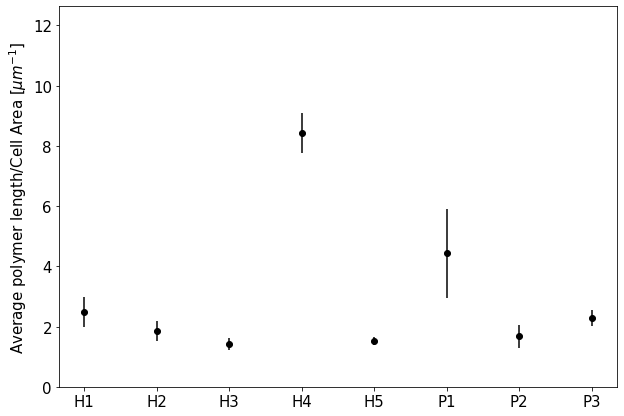

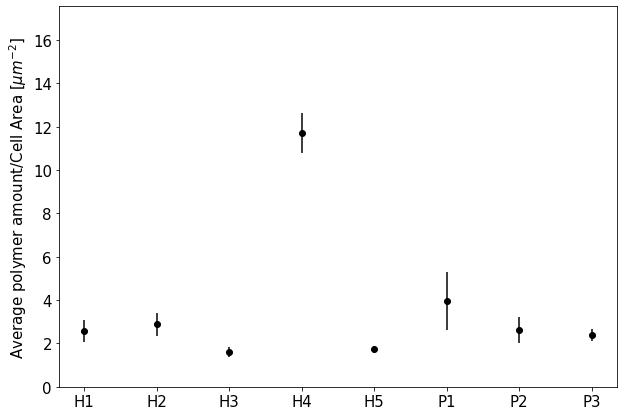

In [121]:
plot_results(Results,'L','SL','Average polymer length/Cell Area [$\mu m ^{-1}$]','length')
plot_results(Results,'I','SI','Average polymer amount/Cell Area [$\mu m ^{-2}$]','poly')